# Baseline Solution for Predicting Olympic Medal Count

This notebook implements and analyzes a naive baseline predictive model for the following purposes:
 1. To showcase the power of Featuretools' abstractions for code brevity and clarity
 2. To make a case for interpretable models
 
This notebook is meant as a companion notebook to [FeaturetoolsPredictiveModeling.ipynb](FeaturetoolsPredictiveModeling.ipynb). That notebook explains the concepts of Feature Engineering and Machine Learning in more depth. While the solutions here will outperform random guessing, feature engineering is necessary if we want significantly better results.

In [1]:
import pandas as pd
import numpy as np
import featuretools as ft
from featuretools.primitives import Count, NUnique
from ml import (score_predictions,
                bin_labels,
                TimeSeriesSplitByDate,
                fit_and_score)
from load_entityset import load_entityset
from utils import get_feature_importances
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, RobustScaler
from IPython.display import display
import os
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
dir_path = os.getcwd()
ROOT_DATA_FOLDER = os.path.join(dir_path,"data/olympic_games_data")

### Load in data and labels

In [3]:
es = load_entityset(data_dir=ROOT_DATA_FOLDER)
label_file = os.path.join(ROOT_DATA_FOLDER, "num_medals_by_country_labels.csv")
label_df = pd.read_csv(label_file,
                       parse_dates=['Olympics Date'],
                       usecols=['Number of Medals', 'Olympics Date', 'Country'],
                       encoding='utf-8')
# Sort by the date of the Olympics, and by the country (to maintain a consistent ordering)
label_df.sort_values(['Olympics Date', 'Country'], inplace=True)
# label_df.head()

load_entityset.py:173: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  columns_to_pull_from_similar]
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [4]:
# Just want the Country and time to compute features (we're removing the label column here)
cutoff_times = label_df[['Country', 'Olympics Date']]
# Code is the index of the "countries" entity in the entityset (short for Country Code)
cutoff_times = cutoff_times.rename(columns={'Country': 'Code'})

# Baseline Predict: Mean number of past medals

We will calculate the mean number of medals won by a country in the past, and use that as our prediction for the future. This solution does not use any machine learning.

### Define features using Featuretools

In [5]:
# total number of medals per country
total_num_medals = Count(es['medals_won']['medal_id'], es['countries'])
# Number of unique Olympic Games each country has been present at
count_num_olympics = NUnique(es['countries_at_olympic_games']['Olympic Games ID'],
                             es['countries'])
# Mean number of medals = total medals across all previous Olympics / number of previous Olympics
mean_num_medals = (total_num_medals / count_num_olympics).rename("mean_num_medals")

### Compute features

In [6]:
feature_matrix = ft.calculate_feature_matrix([mean_num_medals],
                                             cutoff_time=cutoff_times,
                                             cutoff_time_in_index=True,
                                             verbose=True)
feature_matrix.tail()

Progress: 100%|██████████| 27/27 [00:14<00:00,  1.01cutoff time/s]


,,mean_num_medals
Code,time,
TUN,2012-06-29,1.25
TUR,2012-06-29,5.20
UKR,2012-06-29,17.00
USA,2012-06-29,71.20
UZB,2012-06-29,3.50


### How hard is this to do without Featuretools?

Computing the same quantity is a bit complicated: for each (Country, Olympics Date) combo, we have to compute the average number of medals *prior* to that date. The very first Olympics for each country would thus have a `np.nan` value for this average, since there is no data prior to that point.

Therefore, we prepend an additional row for each country for the Olympics prior to its first entry (with a `nan` for the number of medals won), and then add 4 years to each row of the whole DataFrame. Then we can group by the "Country" and use the Pandas expanding mean function to calculate the historical mean from all of the previous medals won by a Country.

In [7]:
indexers = ['Olympics Date', 'Country']
avg_num_medals = label_df

def add_years(dt, num):
    year = dt.year + num
    return pd.Timestamp(year=year, month=dt.month, day=dt.day)

# Find the minimum date for each and subtract 4 years
prev_olympics = (avg_num_medals.groupby('Country')['Olympics Date']
                               .min()
                               .apply(lambda df: add_years(df, -4))
                               .to_frame()
                               .reset_index(drop=False))
# Add these rows in and resort
avg_num_medals = (avg_num_medals.append(prev_olympics, ignore_index=True)
                                .sort_values(indexers))
# Now add 4 years to the date so that when we take the expanding_mean(),
# we leave out the number of medals won at the current olympics
avg_num_medals['Olympics Date'] = avg_num_medals['Olympics Date'].apply(
    lambda df: add_years(df, 4))

avg_num_medals = avg_num_medals.set_index(indexers)
mean_num_medals_over_time = (avg_num_medals.groupby(level='Country')
                                           .expanding()
                                           .mean()
                                           .apply(lambda df: df.iloc[:-1])
                                           .reset_index(drop=True, level=0)
                                           .reset_index(drop=False, level=[0, 1])
                                           .sort_values(indexers)
                            )[indexers + ['Number of Medals']]
mean_num_medals_over_time = mean_num_medals_over_time[
    mean_num_medals_over_time['Olympics Date'] < pd.Timestamp('1/1/2016')]

mean_num_medals_over_time.tail()

,Olympics Date,Country,Number of Medals
1101,2012-06-29,UKR,17.0
1146,2012-06-29,USA,71.2
1152,2012-06-29,UZB,3.5
1164,2012-06-29,VIE,1.0
1185,2012-06-29,ZIM,2.0


### How well does this predictor do?

In [9]:
# Countries that didn't take part in the previous Olympics have default nan values in the dataframe
# Set them to the mean number of medals for that year
baseline1 = feature_matrix.copy()
null_predictions = baseline1['mean_num_medals'].isnull()
means = (baseline1.groupby(level='time')['mean_num_medals'].mean().to_frame())
baseline1[null_predictions] = (baseline1[null_predictions].drop(['mean_num_medals'], axis=1).join(means))

# Fill the 1896 olympics with 0 since we have no data to go off of
baseline1.fillna(0, inplace=True)
baseline1 = baseline1['mean_num_medals']
baseline1.head(20)

Code  time               
AUS   1896-06-29 00:00:00     0.0
AUT   1896-06-29 00:00:00     0.0
DEN   1896-06-29 00:00:00     0.0
FRA   1896-06-29 00:00:00     0.0
GBR   1896-06-29 00:00:00     0.0
GER   1896-06-29 00:00:00     0.0
GRE   1896-06-29 00:00:00     0.0
HUN   1896-06-29 00:00:00     0.0
SUI   1896-06-29 00:00:00     0.0
USA   1896-06-29 00:00:00     0.0
ZZX   1896-06-29 00:00:00     0.0
AUS   1900-06-29              2.0
AUT   1900-06-29              5.0
BEL   1900-06-29              7.4
BOH   1900-06-29              7.4
CAN   1900-06-29              7.4
CUB   1900-06-29              7.4
DEN   1900-06-29              6.0
ESP   1900-06-29              7.4
FRA   1900-06-29             11.0
Name: mean_num_medals, dtype: float64

In [10]:
y = label_df['Number of Medals'].values
y_binary = (y >= 10).astype(int)
binned_labels, bins = bin_labels(label_df['Number of Medals'], [2, 6, 10, 50])
y_binned = binned_labels.values

# Time-based cross-validation (for each Olympics starting in 1960, use all historical data in past)
splitter = TimeSeriesSplitByDate(dates=label_df['Olympics Date'],
                                 earliest_date=pd.Timestamp('1/1/1960'))

In [11]:
predictions = baseline1
scores_over_time = score_predictions(splitter,
                                     predictions,
                                     y,
                                     y_binary,
                                     y_binned)
for scoring_func, scores in scores_over_time.items():
    print "mean %s score: %.2f +/- %.2f" % (scoring_func,
                                            np.mean(scores),
                                            np.std(scores))

mean f1 score: 0.70 +/- 0.06
mean mse score: 91.79 +/- 69.90
mean f1_micro score: 0.48 +/- 0.07
mean r2 score: 0.72 +/- 0.10
mean roc_auc score: 0.79 +/- 0.04


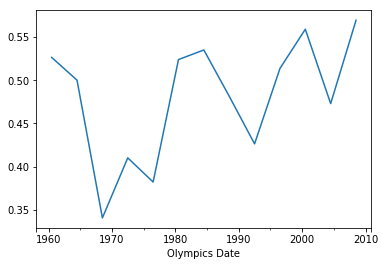

In [12]:
dates = splitter.dates.drop_duplicates()
dates = dates[dates['Olympics Date'] >= pd.Timestamp('1/1/1960')][:-1]['Olympics Date']
pd.Series(scores_over_time['f1_micro'], index=dates).plot()

### Quick analysis

Our AUC (a standard metric for binary classification, with 1.0 as a perfect score) is already very good. We get 0.79 with no machine learning at all. However, we can substantially improve this score (.94) with Feature Engineering, which we will see in the [Featuretools Predictive Modeling](FeaturetoolsPRedictiveModeling.ipynb) notebook.

Our lowest interpretable score is the binned classifaction score: f1_micro, an f1 score averaged across each independent training example, also with a maximum of 1.0.
(Sci-kit Learn has a good [explanation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) of this metric)

Since we have no good way of knowing what a good "Mean Square Error" is for the regression case of the problem, we'll refer back to the binned case for an example of the hardest version of this problem.

Also, looking at the graph of scores over time, it seems our average gets better over time, albeit with large spikes for certain years. We can maybe attribute this to better averaging over time. The impact of international events on these scores is explored further in results section of the [other](FeaturetoolsPredictiveModeling.ipynb) notebook.

<p>
    <img src="https://www.featurelabs.com/img/logo.png" alt="Featuretools" />
</p>


Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact.html).